# Persistence images for neurons in the "Bacci" archive (neuromorpho.org) 

In [37]:
import pymongo
import sys, os
import numpy as np
from sklearn.neighbors import KernelDensity 
sys.path.append('../')
from src import swcfunctions
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import requests 
%matplotlib inline

client = pymongo.MongoClient(host="mongodb://localhost/27017/")
db = client.aibs

In [17]:
bacci_swc_files = os.listdir('../data/Bacci/CNG version/')
pbcodes = {}

In [30]:
for i, f in enumerate(bacci_swc_files): 
    name = f.split('.')[0]
    path = '../data/bacci/CNG version/'+f
    ntree = swcfunctions.NTree(path)
    pbcodes[name] = ntree.get_persistence_barcode()

In [31]:
num_cells = len(pbcodes)
cell_name = [a for a in list(pbcodes.keys())]

In [32]:
X_grid, Y_grid = np.mgrid[0:600:400j,0:600:400j] 
grid = np.vstack([X_grid.ravel(),Y_grid.ravel()])
Zs = {}

In [33]:
for i, a in enumerate(pbcodes): 
    val = np.array([*zip(*pbcodes[a])])
    skl_kernel = KernelDensity(bandwidth=43.48)
    skl_kernel.fit(val.T)
    Zs[a] = np.exp(skl_kernel.score_samples(grid.T))

In [34]:
# Retrieve cell images from source 
png_urls = {a['neuron_name']:a['png_url'] for a in db.nmorpho.find({'archive':"Bacci"})}

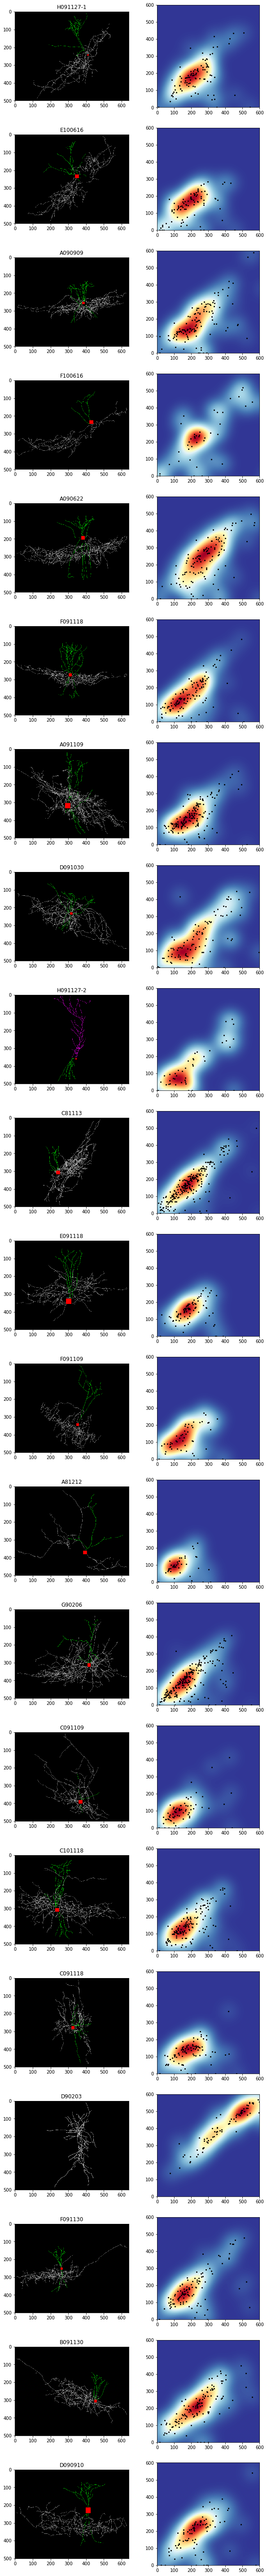

In [36]:
fig, ax = plt.subplots(21,2,figsize=(10,105))
axs = ax.flatten()
for i in range(len(cell_name)): 
    name = cell_name[i]
    axs[2*i].imshow(Image.open(requests.get(png_urls[name], stream=True).raw))
    axs[2*i].set_title(name)
    v0,v1 = np.array([*zip(*list(pbcodes[name]))])
    axs[2*i+1].imshow(np.rot90(Zs[name].reshape(400,-1)), cmap=plt.cm.RdYlBu_r, extent=[0, 600, 0, 600])
    axs[2*i+1].plot( v0, v1, 'k.', markersize=4)
    axs[2*i+1].set_xlim([0, 600])
    axs[2*i+1].set_ylim([0, 600])